Epoch 100, Loss: 0.25735363364219666
Epoch 200, Loss: 0.1599818915128708
Epoch 300, Loss: 0.1062827780842781
Epoch 400, Loss: 0.07578008621931076
Epoch 500, Loss: 0.05828280746936798
Epoch 600, Loss: 0.048555389046669006
Epoch 700, Loss: 0.04347687587141991
Epoch 800, Loss: 0.04102502390742302
Epoch 900, Loss: 0.03993793576955795
Epoch 1000, Loss: 0.03949699178338051
Overwrote ‘cycle’ in dataset.csv with Fourier predictions.


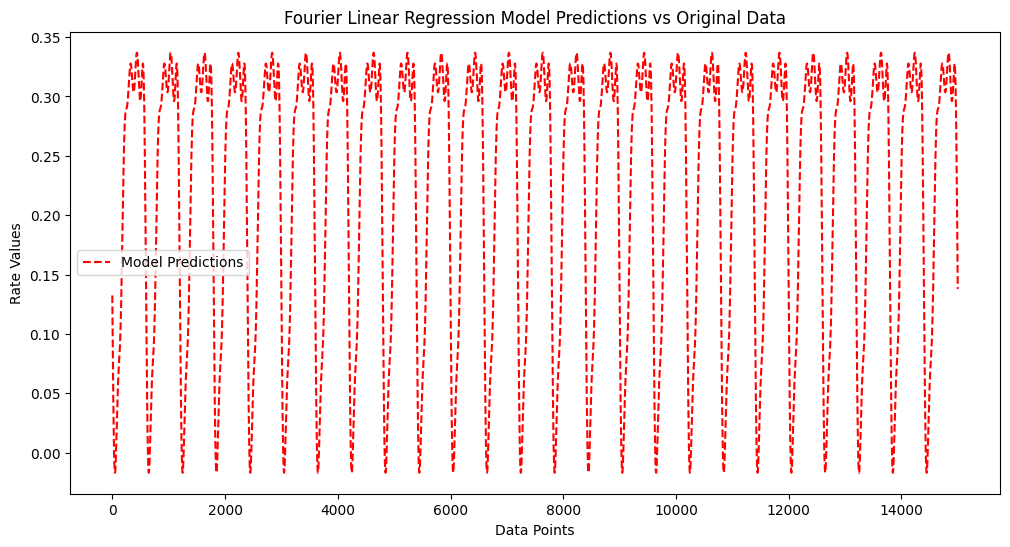

In [2]:
import pandas as pd
import numpy as np
import torch
import csv

# Load dataset
dataset_path = 'dataset.csv'
dataset = pd.read_csv(dataset_path)
dataset['OccupancyDateTime'] = pd.to_datetime(
    dataset['OccupancyDateTime'],
    format='%Y-%m-%d %H:%M:%S'
)

rate_values = torch.FloatTensor(dataset['rate'].values).view(-1, 1).squeeze()

# Fourier series expansion
def create_fourier_series(data, num_terms, period):
    x = torch.FloatTensor(np.arange(len(data))).unsqueeze(1)
    fourier_terms = x.clone()
    for n in range(1, num_terms + 1):
        cos_term = torch.cos(n * 2 * np.pi * x / period)
        sin_term = torch.sin(n * 2 * np.pi * x / period)
        fourier_terms = torch.cat((fourier_terms, cos_term, sin_term), axis=1)
    return fourier_terms[:, 1:]

# Model definition
class FourierLinearRegression(torch.nn.Module):
    def __init__(self, input_feature):
        super(FourierLinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_feature, 1)

    def forward(self, x):
        return self.linear(x).squeeze()

# Hyperparameters
N = 5
period = 600
lr = 0.05
num_epochs = 1000

# Data preparation
fourier_series = create_fourier_series(rate_values, N, period)
input_feature = fourier_series.shape[1]

# Model initialization
model = FourierLinearRegression(input_feature)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(fourier_series)
    loss = loss_function(predictions, rate_values)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

preds = model(fourier_series).detach().numpy()  # shape (n,)

# assign back into your DataFrame
dataset['cycle'] = preds

# 8. Persist the updated DataFrame to the SAME file
dataset.to_csv(dataset_path, index=False)
print(f"Overwrote ‘cycle’ in {dataset_path} with Fourier predictions.")
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# Plotting
plt.figure(figsize=(12, 6))

plt.plot(dataset['cycle'], label='Model Predictions', color='red', linestyle='--')
plt.title('Fourier Linear Regression Model Predictions vs Original Data')
plt.xlabel('Data Points')
plt.ylabel('Rate Values')
plt.legend()
plt.show()